<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/SPTK_analysis_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPTK analysis-synthesis demonstration

This notebook provides a demonstration of SPTK.

Author: Takenori Yoshimura ([@takenori-y](https://github.com/takenori-y))

## Install

In [ ]:
!apt-get install sox

In [ ]:
!git clone https://github.com/sp-nitech/SPTK.git

In [ ]:
!cd SPTK; make

In [ ]:
%env PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/content/SPTK/bin
!pip install -r SPTK/tools/requirements.txt
# You can prepare a python environment via the following commands:
# !cd SPTK/tools; make venv

## Show waveform

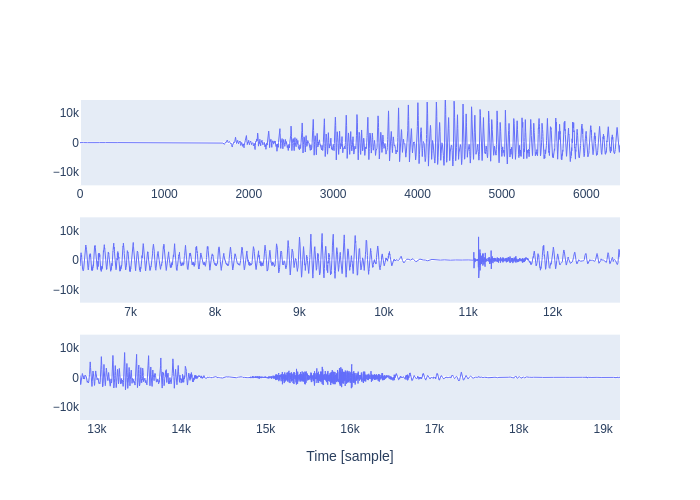

In [ ]:
!x2x +sd SPTK/asset/data.short | gwave -i 3 data.png
from IPython.display import Image
Image("data.png")

In [ ]:
!sox -c 1 -t s16 -r 16000 SPTK/asset/data.short -t wav data.org.wav
from IPython.display import Audio
Audio("data.org.wav")

## Extract mel-cepstrum

### Analyze sample data

Condition:
*   Frame shift = 80 points (= 5 ms)
*   Frame length = 400 points (= 25 ms)
*   FFT length = 512 points
*   Blackman window
*   Warping factor = 0.42 (this is suitable for 16 kHz)
*   Order of coefficients = 24


In [ ]:
!x2x +sd SPTK/asset/data.short | \
    frame -l 400 -p 80 | \
    window -l 400 -L 512 -w 0 | \
    mgcep -l 512 -m 24 -a 0.42 > data.mgc

### Show specturm of 30th frame

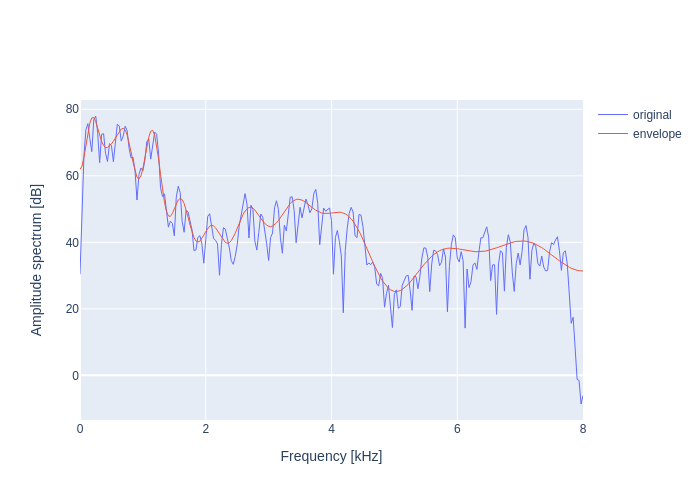

In [ ]:
!x2x +sd SPTK/asset/data.short | \
    frame -l 400 -p 80 | \
    window -l 400 -L 512 | \
    spec -l 512 | \
    bcut -s $((257*30)) -e $((257*31-1)) > data.spec

!mgc2sp -l 512 -m 24 -a 0.42 data.mgc | \
    bcut -s $((257*30)) -e $((257*31-1)) >> data.spec

!fdrw -n 257 -z 0 -g -names "original,envelope" \
    -yname "Amplitude spectrum [dB]" \
    -xname "Frequency [kHz]" -xscale 8 \
    data.spec data.spec.png

from IPython.display import Image
Image("data.spec.png")

## Extract pitch

### Analyze sample data

Condition:
*   Frame shift = 80 points (= 5 ms)
*   Lower frequency = 60 Hz
*   Upper frequency = 200 Hz
*   Sample rate = 16 kHz
*   Algorithm = RAPT

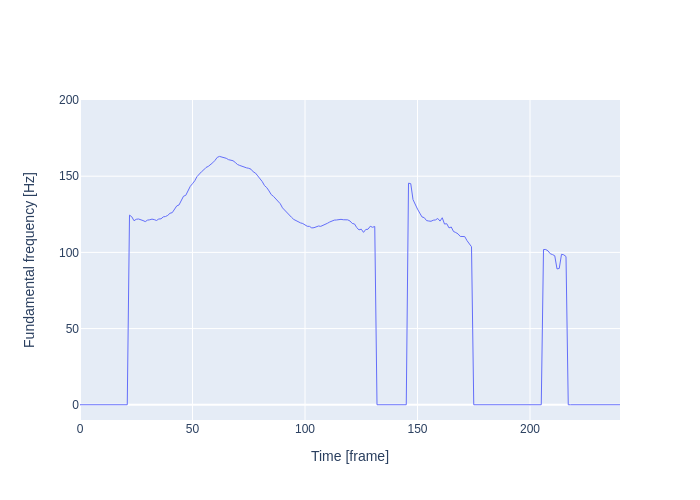

In [ ]:
!x2x +sd SPTK/asset/data.short | \
    pitch -p 80 -L 60 -H 200 -s 16 -o 0 > data.pit

!sopr -magic 0 -INV -m 16000 -MAGIC 0 data.pit > data.f0

!fdrw -g -y -10 200 \
    -yname "Fundamental frequency [Hz]" \
    -xname "Time [frame]" \
    data.f0 data.f0.png

from IPython.display import Image
Image("data.f0.png")

## Synthesize waveform

### Run MLSA filter

In [ ]:
!excite -p 80 data.pit | \
    mglsadf -p 80 -m 24 -a 0.42 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.syn.wav

from IPython.display import Audio
Audio("data.syn.wav")

### Make fast-speaking voice

In [ ]:
!excite -p 40 data.pit | \
    mglsadf -p 40 -m 24 -a 0.42 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.fast.wav

from IPython.display import Audio
Audio("data.fast.wav")

### Make slow-speaking voice

In [ ]:
!excite -p 160 data.pit | \
    mglsadf -p 160 -m 24 -a 0.42 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.slow.wav

from IPython.display import Audio
Audio("data.slow.wav")

### Make hoarse voice

In [ ]:
!mseq -l $(x2x +sa SPTK/asset/data.short | wc -l) | \
    mglsadf -p 80 -m 24 -a 0.42 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.hoarse.wav

from IPython.display import Audio
Audio("data.hoarse.wav")

### Make robotic voice

In [ ]:
!train -p 200 -l $(x2x +sa SPTK/asset/data.short | wc -l) | \
    mglsadf -p 80 -m 24 -a 0.42 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.robot.wav

from IPython.display import Audio
Audio("data.robot.wav")

### Make child-like voice

In [ ]:
!sopr -m 0.4 data.pit | \
    excite -p 80 | \
    mglsadf -p 80 -m 24 -a 0.1 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.child.wav

from IPython.display import Audio
Audio("data.child.wav")

### Make deep voice

In [ ]:
!sopr -m 2 data.pit | \
    excite -p 80 | \
    mglsadf -p 80 -m 24 -a 0.6 data.mgc | \
    x2x +ds -r | \
    sox -c 1 -t s16 -r 16000 - -t wav data.deep.wav

from IPython.display import Audio
Audio("data.deep.wav")